In [1]:
import sqlite3 as sql 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


#conn = sql.connect('DataPipeline/test.db')
#q = ''' select * from spy where date(expiry) = "2023-04-10" and strike = 391 and type = "Put"'''
#tmp = pd.read_sql(q, conn).tail(1)
#tick = yf.Ticker(stock).history(period = '5d', interval = '1m')

stock = '^GSPC'
tick = yf.Ticker(stock).history(start = '1900-04-01')
tick = tick[['Open','High','Low', 'Close']].copy()

Yang and Zhang estimator (effective estimator)

Using normalized open high low and close values. 

$$
\sigma = \sqrt{{\sigma_o^2}+k\sigma_c^2+(1-k)\sigma_{rs}^2}
\\ \ \\
\sigma_o^2 = \frac{1}{N-1}\sum_{i=1}^{N}ln{\frac{o_i}{c_{i-1}}^2}
\\ \ \\
 \sigma_c^2 = \frac{1}{N-1}\sum_{i=1}^{N}ln{\frac{c_i}{o_{i-1}}^2}
 \\ \ \\
 \sigma_{rs}^2 = \frac{1}{N-1}\sum_{i=1}^{N}(ln{\frac{h_i}{c_i}})(ln{\frac{h_i}{o_i}}) + (ln{\frac{l_i}{c_i}})(ln{\frac{l_i}{o_i}})
 \\ \ \\
 k = \frac{0.34}{1.34 + \frac{N+1}{N-1}}
 \\ \ \\

 \hat{\sigma}_{y,z} = \hat{\sigma}^2_0  + k \hat{\sigma}^2_c + (1-k)\hat{\sigma}_{r,s}
$$

The final sum is the weighted sum of estimators.

In [2]:
# Estimate Volatility of a stock. 
def est_vol(df, lookback=10):
    """ 
    This is the Yang-Zheng (2005) Estimator for Valatlity; 
        Yang Zhang is a historical volatility estimator that handles 
            1. opening jumps
            2. the drift and has a minimum estimation error 
    """
    o = df.Open
    h = df.High
    l = df.Low
    c = df.Close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(window=lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result 

# apply Yang-Zheng (2005) Estimator for volatility
vol_est = est_vol(tick)

# calculate the realized voaltility of the stock price
ret = tick.mean(axis = 1).pct_change().dropna()
returns = np.log(1+ret).rolling(10).std() * np.sqrt(252)

/Users/jerald/opt/miniconda3/envs/ts/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


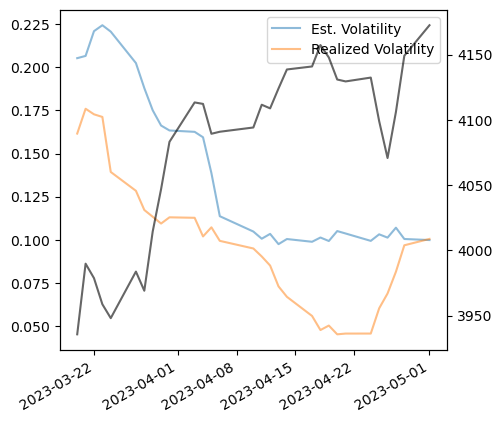

In [3]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(vol_est[-30:], label = 'Est. Volatility', alpha = 0.5)
ax.plot(returns[-30:], label = 'Realized Volatility', alpha = 0.5)
ax1 = ax.twinx()
ax1.plot(tick.mean(axis = 1)[-30:], label = 'Actual Returns', color = 'black', alpha = 0.6)
ax.legend()
fig.autofmt_xdate()
plt.show()

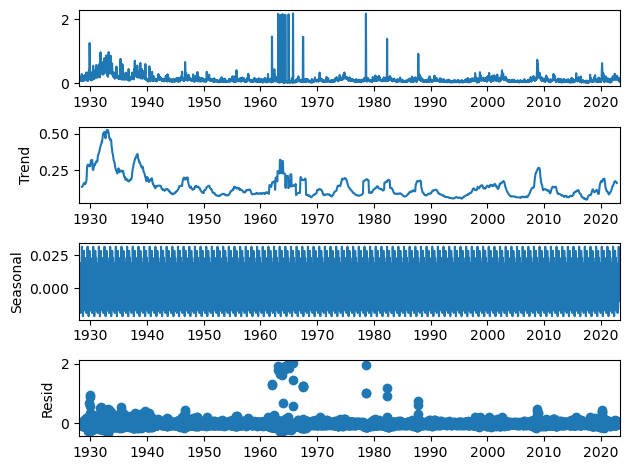

In [4]:
# decompose the realized volatility 
from statsmodels.tsa.seasonal import seasonal_decompose
series = returns.copy()
series.index = [pd.to_datetime(str(x)[:10]) for x in series.index]
series = series.resample('W').mean().bfill()
result = seasonal_decompose(series, model='additive')
result.plot()
plt.show()